# Import

In [121]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import pandas as pd
from lmfit import minimize, Parameters, Parameter, report_fit
from scipy.integrate import odeint

# Definition of the model

For the fitting we use the cumulative case numbers, we need to add a compartment here to count them. In our model, all detected cases end up in Q2, which is why we count the number of people entering there.


In [122]:
def f(xs, t, ps):
    '''Coupled Opinion and Epidemic Model'''
    timeslot_1 = 589 - 549 #01.07.2021 - 10.08.2021
    timeslot_2 = timeslot_1 + 689-589 # 10.08.2021 - 18.11.2021
    try:
        if t<(timeslot_1):
            ρ = ps['ρ1'].value 
            σ = ps['σ1'].value 
            τ = ps['τ1'].value 
        elif t>=timeslot_1 and t < timeslot_2:
            ρ = ps['ρ2'].value 
            σ = ps['σ2'].value 
            τ = ps['τ2'].value
        else:
            ρ = ps['ρ3'].value
            σ = ps['σ3'].value
            τ = ps['τ3'].value
    except:
        ρ,σ,τ = ps
        
    S,E,Q_1,Q_2,I,V,    L,U,D,R,H, Q_C = xs
    N = S + E + Q_1 + Q_2 + I + V
    Q = Q_1 + Q_2
    
    R_G = a*R/(1+a*R)

    η_1 = 1/2.5 * 0.897 * (S/(S+V))
    η_2 = 1/2.5 * 0.103
    η_3 = 1/2.5 * 0.897 * (V/(S+V))
    
    dS = -β*I/(N-Q) * S - ψ*( 1 - (R + τ*U)/N + D/N ) * S - ρ * (1- (R + τ * U)/N) * S + η_1 * Q_1
    dE = β * I/(N-Q) * S + β * δ * I/(N-Q) * V - ρ * ( 1- (R + τ * U)/N) * E - γ * E
    dQ_1 = ρ * ( 1- (R + τ * U)/N) * S + ρ * ( 1- (R + τ * U)/N) * E + ρ * ( 1- (R + τ * U)/N) * V - η_1 * Q_1 - η_2 * Q_1 - η_3 * Q_1
    dQ_2 = σ * ( 1- R/N) * I + η_2 * Q_1 - r_2 * Q_2
    dI = γ * E - σ * ( 1- R/N) * I - r_1 * I
    dV = r_1 * I + r_2 * Q_2 + η_3 * Q_1 + ψ * ( 1- (R + τ * U)/N + D/N) * S - β * δ * I/(N-Q) * V - ρ * ( 1- (R + τ * U)/N) * V
    
    dL = -α * R/N * L*(1-(I+Q_2)/N) - α * U/N * L - α * D/N * L*(1+(I+Q_2)/N) + ϕ * R + ϕ * H

    dU = α * U/N * L-  χ* R_G/N * U *(1-(I+Q_2)/N) - χ * D/N * U*(1+(I+Q_2)/N) - λ * U
    dD = α * D/N * L*(1+(I+Q_2)/N) + χ * D/N * U*(1+(I+Q_2)/N) - λ * D 
    dR = α * R/N * L* (1-(I+Q_2)/N) + χ * R_G/N * U*(1-(I+Q_2)/N) - ϕ * R 
    dH = λ * D + λ * U - ϕ * H
    
    #cumulative numbers:
    dQ_C = σ * ( 1- R/N) * I + η_2 * Q_1
    
    
    return [dS,dE,dQ_1,dQ_2,dI,dV,dL,dU,dD,dR,dH,dQ_C]

# Definition of the fixed parameters

In [123]:
#Parameter for the epidemic model
β = 0.4
r_1 = 0.1
r_2 = 1/12
γ = 1/4
δ = 0.28
ψ = 0.00199


#Opinion model
α = 0.071
ϕ = 1.9685e-5
χ = 0.0031
λ = 4.2972e-5

#Holling Type 2
a = 0.8

# Definition of the residual and the initial conditions

The residual is needed for the optimisation.

In [124]:
def g(t, x0, ps):
    """Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0"""
    x = odeint(f, x0, t, args=(ps,))
    return x

def residual(ps, ts, data):
    
    #initial conditions for the compartments
    U = 140000
    D = 1400000
    R = 350000
    H = 0
    L = 70000000 - D - R - H - U

    E = ps['E'].value
    Q_1 = ps['Q_1'].value
    Q_2 = 3649881-3642450 #Calculate from the incidence of the 1.7.2021
    I = ps['I'].value
    V = 34715161
    S = 70000000 - E - Q_1 - Q_2 - I - V
    
    #define the number of people which are or were already infected 
    Q_C = 3729033
    
    x0 = [S, E, Q_1, Q_2, I, V,    #epidemics
      L, U, D, R, H, Q_C]           #oppinion;

    model = g(ts, x0, ps) #model values
    
    #return the cumulative compartment
    return (model[:,11]-data).ravel()

# Importing and preparing data, setting time

The exact number of new infections is usually not available, instead we use cumulative case numbers. These are calculated and stored in an array.

In [125]:
datapath = '/home/tom/Schreibtisch/1M_Semester/cs-repo/CS_repository/Case-Studies-Life-Sciences/' # Path which leads to RKI data

data = pd.read_excel(str(datapath + "00 Bundeslaender Gesamt.xlsx"), sheet_name='Gesamt', header=0)

data = data['Fälle']
train = []

days = 732 - 549 #from 01.07.2021 to 31.12.2021

#depends on the days we want to observe
t = np.linspace(0,days, days+1)

for i in range(days+1):
    train.append(sum(data[0:548+i]))
data = np.array(train)
print(data)

[3739560 3740256 3740889 3741472 3742398 3743412 3744413 3745460 3746492
 3747544 3748496 3749928 3751576 3753198 3754750 3756349 3757871 3759232
 3761227 3763399 3765521 3767464 3769536 3771454 3773142 3775596 3778328
 3781046 3783356 3785871 3788270 3790519 3793694 3797218 3800797 3804279
 3808145 3811733 3814935 3819680 3825062 3830762 3836175 3842241 3848014
 3853066 3860245 3867892 3876342 3884333 3893489 3901449 3908156 3917557
 3928108 3939048 3949241 3959185 3968270 3975057 3985550 3997426 4010451
 4021460 4032943 4042752 4049986 4060110 4071957 4083902 4094187 4104282
 4112524 4118554 4127244 4137599 4147249 4155908 4163908 4170755 4176121
 4183960 4192908 4201982 4210205 4218576 4225769 4231614 4240002 4249758
 4259214 4267375 4275701 4282930 4289074 4297787 4307456 4317088 4325818
 4334986 4343111 4350100 4360066 4371201 4382792 4393565 4405684 4417048
 4426680 4440831 4457602 4474973 4490810 4507960 4523456 4536470 4555404
 4577704 4600952 4622269 4644474 4664729 4680724 47

# Define the parameters we want to fit and their range
This code is only used if we fit the parameters again. Otherwise, we load the parameters from the picewise_coupled_params.txt.

In [126]:
params = Parameters()
params.add('ρ1', value=2.254299642695523076e-04, min=0, max=1)
params.add('σ1', value=1.289842845929302928e-01, min=0, max=0.5)
params.add('τ1', value=2.862982799135161960e-01, min=0, max=1)

params.add('ρ2', value=9.479595046505973066e-04, min=0, max=1)
params.add('σ2', value=6.204065139942172014e-02, min=0, max=0.5)
params.add('τ2', value=9.053974844299403912e-01, min=0, max=1)

params.add('ρ3', value=1.358218040084346878e-03, min=0, max=1)
params.add('σ3', value=1.785810847255331346e-01, min=0, max=0.5)
params.add('τ3', value=9.663423003150186652e-01, min=0, max=1)

params.add('E', value=7.816784118158841011e+03, min=10, max=10000)
params.add('Q_1', value=8.671621253939785674e+03, min=1000, max=10000)
params.add('I', value=7.323703916751436736e+03, min=100, max=10000)

# Fit the model and find predicted values


In [127]:
#Run this code if the parameters need to be fitted again

#result = minimize(residual, params, args=(t, data), method='leastsq')
#final = data + result.residual.reshape(data.shape)

# plot data and fitted curves
#plt.plot(t, data, 'o')
#plt.plot(t, final, '-', linewidth=2);

# display fitted statistics
#report_fit(result)

## Save the calculated parameters in the picewise_coupled_params.txt file.

In [128]:
#run this only if the parameters needed to be calculated again

#ρ1 = result.params['ρ1'].value
#σ1 = result.params['σ1'].value
#τ1 = result.params['τ1'].value

#ρ2 = result.params['ρ2'].value
#σ2 = result.params['σ2'].value
#τ2 = result.params['τ2'].value

#ρ3 = result.params['ρ3'].value
#σ3 = result.params['σ3'].value
#τ3 = result.params['τ3'].value

#E = result.params['E'].value
#Q_1 = result.params['Q_1'].value
#I = result.params['I'].value

#w = [ρ1,σ1,τ1,ρ2,σ2,τ2, ρ3,σ3, τ3, E, Q_1, I]
#print(w)

#np.savetxt('picewise_coupled_params.txt', w, delimiter = ',')


# Taking a look at the model with fitted Parameters

In [129]:
def f2(xs, t):
    #time between new restrictions
    timeslot_1 = 589 - 549
    timeslot_2 = timeslot_1 + 689-589
    
    if t<(timeslot_1):
            ρ = ρ1 
            σ = σ1 
            τ = τ1 
    elif t>=timeslot_1 and t < timeslot_2:
            ρ = ρ2 
            σ = σ2 
            τ = τ2
    else:
            ρ = ρ3
            σ = σ3
            τ = τ3
        
    S,E,Q_1,Q_2,I,V,    L,U,D,R,H,Q_C,Q_V = xs #Q_C
    N = S + E + Q_1 + Q_2 + I + V
    Q = Q_1 + Q_2
    
    R_G = a*R/(1+a*R)

    η_1 = 1/2.5 * 0.897 * (S/(S+V))
    η_2 = 1/2.5 * 0.103
    η_3 = 1/2.5 * 0.897 * (V/(S+V))
    
    dS = -β*I/(N-Q) * S - ψ*( 1 - (R + τ*U)/N + D/N ) * S - ρ * (1- (R + τ * U)/N) * S + η_1 * Q_1
    dE = β * I/(N-Q) * S + β * δ * I/(N-Q) * V - ρ * ( 1- (R + τ * U)/N) * E - γ * E
    dQ_1 = ρ * ( 1- (R + τ * U)/N) * S + ρ * ( 1- (R + τ * U)/N) * E + ρ * ( 1- (R + τ * U)/N) * V - η_1 * Q_1 - η_2 * Q_1 - η_3 * Q_1
    dQ_2 = σ * ( 1- R/N) * I + η_2 * Q_1 - r_2 * Q_2
    dI = γ * E - σ * ( 1- R/N) * I - r_1 * I
    dV = r_1 * I + r_2 * Q_2 + η_3 * Q_1 + ψ * ( 1- (R + τ * U)/N + D/N) * S - β * δ * I/(N-Q) * V - ρ * ( 1- (R + τ * U)/N) * V
    
    dL = -α * R/N * L*(1-(I+Q_2)/N) - α * U/N * L - α * D/N * L*(1+(I+Q_2)/N) + ϕ * R + ϕ * H

    dU = α * U/N * L-  χ* R_G/N * U *(1-(I+Q_2)/N) - χ * D/N * U*(1+(I+Q_2)/N) - λ * U
    dD = α * D/N * L*(1+(I+Q_2)/N) + χ * D/N * U*(1+(I+Q_2)/N) - λ * D 
    dR = α * R/N * L* (1-(I+Q_2)/N) + χ * R_G/N * U*(1-(I+Q_2)/N) - ϕ * R 
    dH = λ * D + λ * U - ϕ * H
    
    #cumulative numbers:
    dQ_C = σ * ( 1- R/N) * I + η_2 * Q_1
    dQ_V = r_2 * Q_2
    
    
    return [dS,dE,dQ_1,dQ_2,dI,dV,dL,dU,dD,dR,dH,dQ_C,dQ_V]

In [140]:
U = 140000
D = 1400000
R = 350000
H = 0
L = 70000000 - D - R - H - U


#load the last fitted parameter
w_load = np.loadtxt('picewise_coupled_params.txt', dtype = float)
ρ1,σ1,τ1,ρ2,σ2,τ2, ρ3,σ3, τ3, E, Q_1, I = w_load

print('ρ1: ' + str(ρ1) + ', ' + 'σ1: ' + str(σ1) + ', ' + 'τ1: ' + str(τ1) + ', ' +
      'ρ2: ' + str(ρ2) + ', ' + 'σ2: ' + str(σ2)+ ', ' + 'τ2: ' + str(τ2)+ ', ' +
      'ρ3: ' + str(ρ3)+ ', ' + 'σ3: ' + str(σ3)+ ', ' + 'τ3: ' + str(τ3)+ ', '+
      'E: ' + str(E)+ ', ' + 'Q_1: ' + str(Q_1)+ ', ' +  'I: ' + str(I) )

Q_2 = 3649881-3642450 #recovered from 12.07-01.07
# https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Situationsberichte/Jul_2021/2021-07-01-de.pdf?__blob=publicationFile
V = 34715161
S = 70000000 - E - Q_1 - Q_2 - I - V
    
#define the number of people which are or were already infected
Q_C = 3729033
Q_V = Q_C - (117/100000) *70e6


x0 = [S, E, Q_1, Q_2, I, V,    #epidemics
      L, U, D, R, H,Q_C,Q_V]   #opinion and Q_C and Q_V

ts = np.linspace(0,183, 183)
Ps = odeint(f2, x0, ts)

ρ1: 0.00019597695322542963, σ1: 0.1524108160070437, τ1: 0.2954975435572986, ρ2: 0.0012823321365258988, σ2: 0.05499123541780154, τ2: 0.570562208187908, ρ3: 7.21931917557761e-06, σ3: 0.18231695056314218, τ3: 0.00013278666183630383, E: 1711.4646269628581, Q_1: 9708.158050998896, I: 9788.464694773647


# Plotting the fitted curve

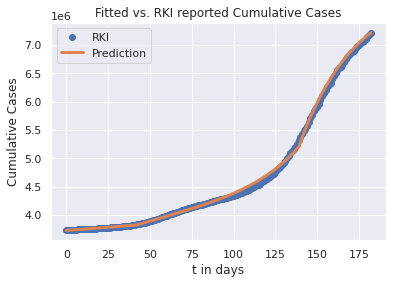

In [131]:
# plot data and fitted curves
plt.plot(t[0:-1], data[0:-1], 'o')
plt.title('Fitted vs. RKI reported Cumulative Cases')
plt.plot(t[0:-1], Ps[:, 11], '-', linewidth=3)
plt.legend(['RKI', 'Prediction'])
plt.xlabel("t in days")
plt.ylabel('Cumulative Cases')
plt.savefig('Simulation_cumulative_cases.jpg', dpi = 500)
plt.show()

# Plotting the Compartments

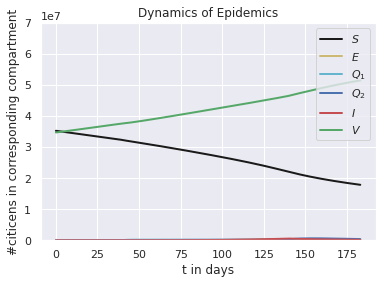

In [132]:
plt.plot(ts,Ps[:,0],'k-', linewidth=2.0)
plt.plot(ts,Ps[:,1],'y-', linewidth=2.0)
plt.plot(ts,Ps[:,2],'c-', linewidth=2.0)
plt.plot(ts,Ps[:,3],'b-', linewidth=2.0)
plt.plot(ts,Ps[:,4],'r-', linewidth=2.0)
plt.plot(ts,Ps[:,5],'g-', linewidth=2.0)

plt.xlabel("t in days")
plt.ylim((0,7e7))
plt.ylabel("#citicens in corresponding compartment")
plt.title("Dynamics of Epidemics")
plt.legend(["$S$","$E$","$Q_1$","$Q_2$","$I$","$V$"])
plt.show()

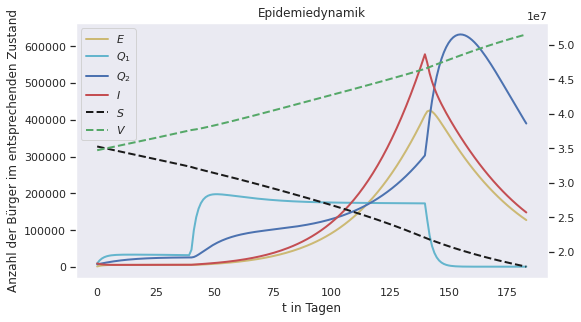

In [133]:
'''
This code can be used to plot all curves in the same plot.
We want two plots with different parametersets in the same plot.
'''

#plt.figure(figsize=(500, 8000), dpi=10)
fig, ax1 = plt.subplots()
fig.set_size_inches(8.46, 4.7)
ax1.set_title('Epidemiedynamik')
ax1.set_xlabel('t in Tagen')
ax1.set_ylabel('Anzahl der Bürger im entsprechenden Zustand')
#ax1.set_title('Dynamics of Epidemics')
#ax1.set_xlabel('t in days')
#ax1.set_ylabel('citizens in corresponding compartment') #,color = 'red'
plot_1 = ax1.plot(ts,Ps[:,1],'y-', linewidth=2.0)
plot_2 = ax1.plot(ts,Ps[:,2],'c-', linewidth=2.0)
plot_3 = ax1.plot(ts,Ps[:,3],'b-', linewidth=2.0)
plot_4 = ax1.plot(ts,Ps[:,4],'r-', linewidth=2.0)
ax1.grid(False)

#ax1.legend(["$S$","$E$","$Q_1$","$Q_2$","$I$","$V$"])
ax1.tick_params(axis ='y')

# Adding Twin Axes
ax2 = ax1.twinx()
plot_0 = ax2.plot(ts,Ps[:,0],'k--', linewidth=2.0)
plot_5 = ax2.plot(ts,Ps[:,5],'g--', linewidth=2.0)
ax2.tick_params(axis ='y')
ax2.grid(False)

#Adding a legend for both plots:
all_plts = plot_1 + plot_2 + plot_3 + plot_4 + plot_0 + plot_5
labels = ["$E$","$Q_1$","$Q_2$","$I$","$S$","$V$"]
plt.legend(all_plts, labels, loc = 'upper left')

plt.savefig('Dynamics_of_epidemics_poster_plot_german.jpg', dpi = 800)
plt.show()

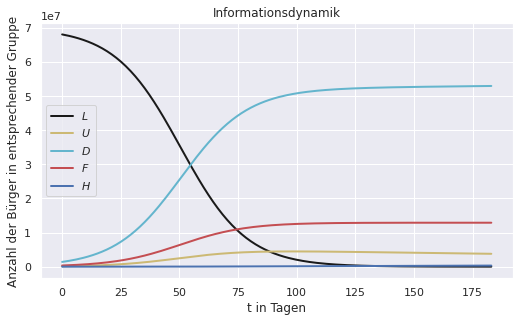

In [134]:
fig, ax1 = plt.subplots()
fig.set_size_inches(8.46, 4.7)

ax1.plot(ts,Ps[:,6],'k-', linewidth=2.0)
ax1.plot(ts,Ps[:,7],'y-', linewidth=2.0)
ax1.plot(ts,Ps[:,8],'c-', linewidth=2.0)
ax1.plot(ts,Ps[:,9],'r-', linewidth=2.0)
ax1.plot(ts,Ps[:,10],'b-', linewidth=2.0)

ax1.set_title('Informationsdynamik')
ax1.set_xlabel('t in Tagen')
ax1.set_ylabel('Anzahl der Bürger in entsprechender Gruppe')

#ax1.set_xlabel("t in days")
#ax1.set_ylabel("citizens in corresponding compartment")
#ax1.set_title("Dynamics of Opinions")
ax1.legend(["$L$","$U$","$D$","$F$","$H$"], loc = 'center left') #changed R to F for the poster
fig.savefig('Dynamics_of_opinion_german.jpg', dpi = 800)
plt.show()

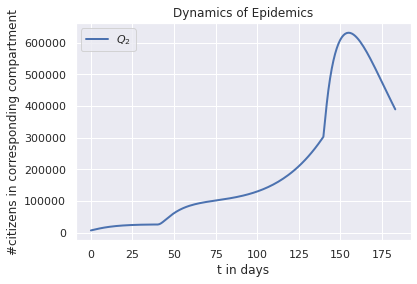

In [135]:
plt.plot(ts,Ps[:,3],'b-', linewidth=2.0)
plt.xlabel("t in days")
plt.ylabel("#citizens in corresponding compartment")
plt.title("Dynamics of Epidemics")
plt.legend(["$Q_2$"])
plt.show()

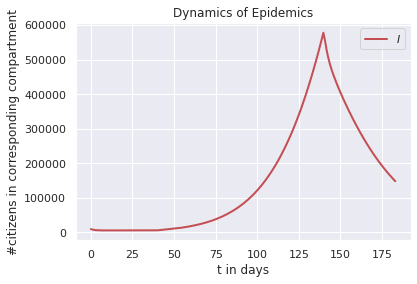

In [136]:
plt.plot(ts,Ps[:,4],'r-', linewidth=2.0)
plt.xlabel("t in days")
plt.ylabel("#citizens in corresponding compartment")
plt.title("Dynamics of Epidemics")
plt.legend(["$I$"])
plt.show()

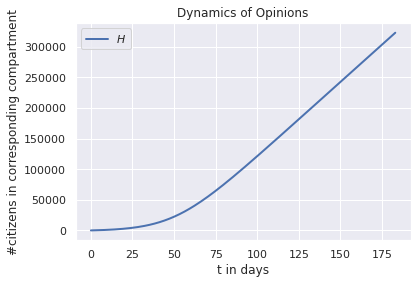

In [137]:
plt.plot(ts,Ps[:,10],'b-', linewidth=2.0)
plt.xlabel("t in days")
plt.ylabel("#citizens in corresponding compartment")
plt.title("Dynamics of Opinions")
plt.legend(["$H$"])
plt.show()

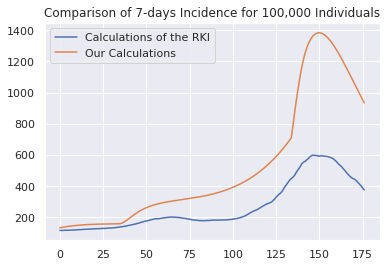

In [138]:
Inzidenz = pd.read_excel(datapath + "00 Bundeslaender Gesamt.xlsx", sheet_name='Gesamt', header=0)['Inzidenz'][549:732-7] # 7 Tage abziehen #Tom
#Inzidenz = pd.read_excel(str(datapath + "/Daten/RKI/Bundesländer/00 Bundeslaender Gesamt.xlsx"), sheet_name='Gesamt', header=0)['Inzidenz'][549:732-7] #Sabine

Q_C = (Ps[:,11]/70000000) * 100000
Q_V = (Ps[:,12]/70000000) * 100000
Model_inzidenz = Q_C[6:-1]-Q_V[1:-6]
ts = np.linspace(0,176, 176)
plt.plot(ts,Inzidenz)
plt.plot(ts, Model_inzidenz)
plt.title("Comparison of 7-days Incidence for 100,000 Individuals")
plt.legend(["Calculations of the RKI", "Our Calculations"])
plt.show()

In [ ]:
#Inzidenz = pd.read_excel(datapath, sheet_name='Gesamt', header=0)['Inzidenz'][549:732-7] # 7 Tage abziehen #Tom
Inzidenz = pd.read_excel(str(datapath + "/Daten/RKI/Bundesländer/00 Bundeslaender Gesamt.xlsx"), sheet_name='Gesamt', header=0)['Inzidenz'][549:732-7] #Sabine

Q_C = (Ps[:,11]/70000000) * 100000
Q_V = (Ps[:,12]/70000000) * 100000
Model_inzidenz = Q_C[6:-1]-Q_V[1:-6]
#print(Model_inzidenz)
ts = np.linspace(0,176, 176)
plt.plot(ts,Inzidenz)
plt.plot(ts, Model_inzidenz)
plt.title("Comparison of 7-days Incidence for 100,000 Individuals")
plt.legend(["Calculations of the RKI", "Our Calculations"])
plt.show()